# **Projeto Final de Algoritmos em Bioinformática - 2025.1**
---
### Discentes:

- **Beatriz Ormond Dias Pereira** - RA: 176084
- **Gabriel Delgado Panovich de Barros** - RA: 176313
- **Jade Fernands Mathey** - RA: 178094
- **João Vitor Moreira Gomes** - RA: 176536
- **Sarah Mynssen Basaglia de Macedo** - RA: 176588
- **Vinicius Groto de Oliveira** - RA: 177217
---
## **Resumo das funções:**

### [read_fasta.py:](#read-fasta)

Função principal, que lê os arquivos do GenBank, os extrai e armazena em armazenamento local. Após isso, extrai os cabeçalhos e as sequências e armazena essas informações em um dicionário e, com esse dicionário, executa todas as funções de análise das sequências extraídas.

### [freq_nucleotideos.py:](#freq-nucleotideos)

Realiza o cálculo das frequências de cada nucleotídeo para cada sequência, armazenando essas informações em um arquivo .csv e plotando em um gráfico através da biblioteca matplotlib.

### [temp_melting.py:](#temp-melting)

Calcula o conteúdo GC de cada sequência de nucleotídeos e utiliza esse cálculo para encontrar a temperatura de melting para cada uma das sequências, armazenando as temperaturas em um arquivo.csv.

### [alinhamento.py:](#alinhamento)

Responsável pelo cálculo dos scores dos alinhamentos global (Needleman-Wunsch) e local (Smith-Waterman), armazenando esses dados em uma tabela .csv.

### [tradutor.py:](#tradutor)

Simula a tradução do material genético de cada sequência, armazenando a tradução em um arquivo .csv, e chama um módulo auxiliar para plotagem da frequências dos aminoácidos traduzidos para cada uma das sequências.

### [freq_aminoacidos.py:](#freq-aminoacidos)

Módulo auxiliar de *tradutor.py*, responsável por calcular as frequências dos aminoácidos de uma sequência e plotar um gráfico de barras contendo essas frequências.

---

## Mais informações:

O projeto na íntegra encontra-se publicado no [GitHub](https://github.com/gabrieldpbarros/AlgBio/tree/master/Projeto%20Final).

---
## Bibliotecas necessárias

In [6]:
!pip install --upgrade pip
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install biopython

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


---
<a id="read-fasta"></a>
## read_fasta.py

Processamento completo.


------INFORMAÇÕES EXTRAÍDAS------


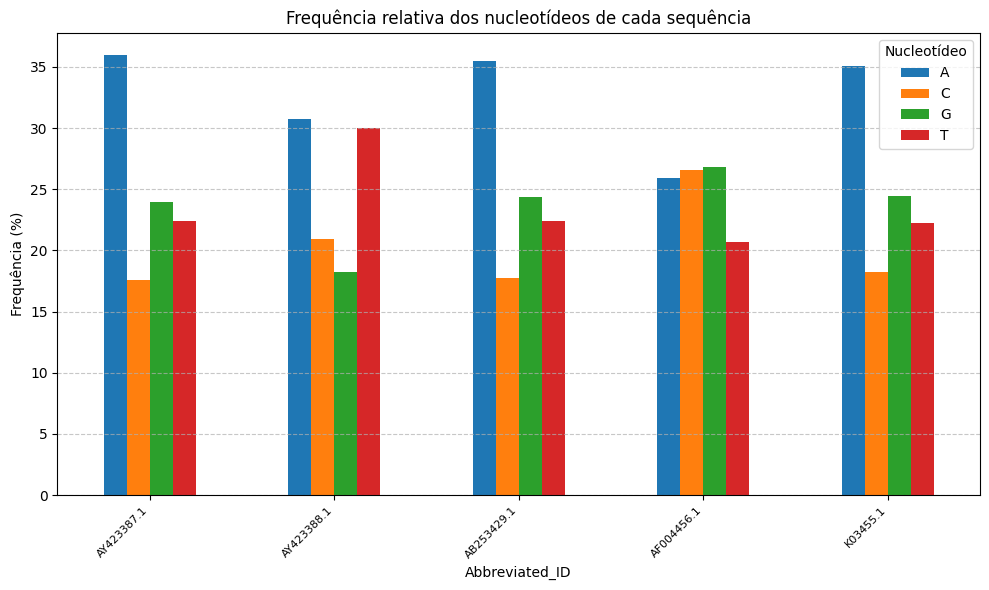

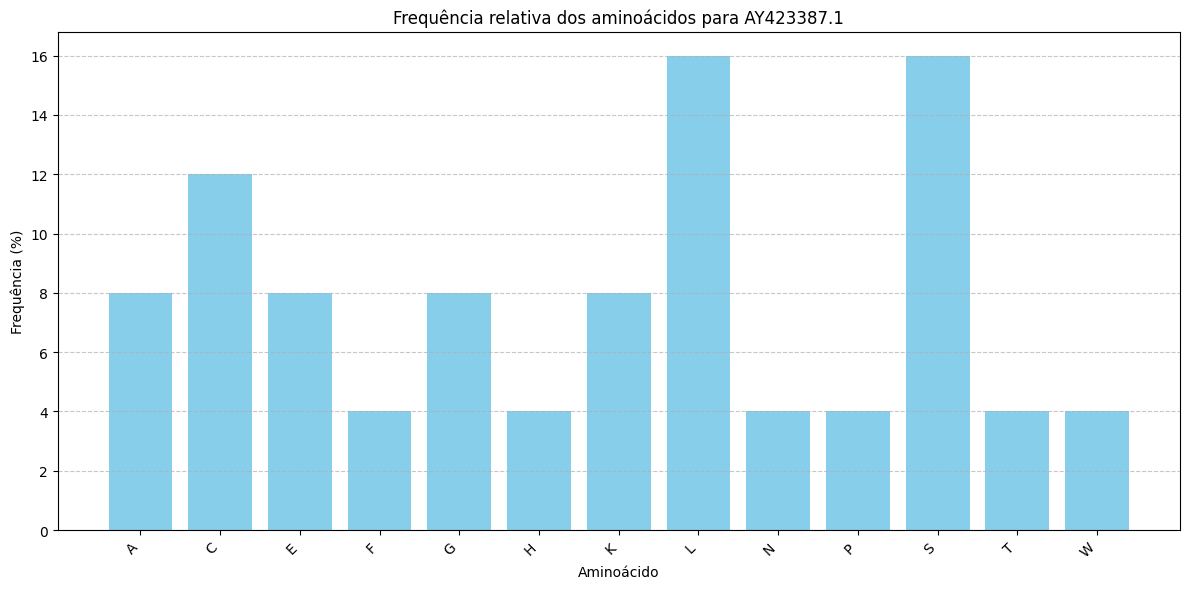

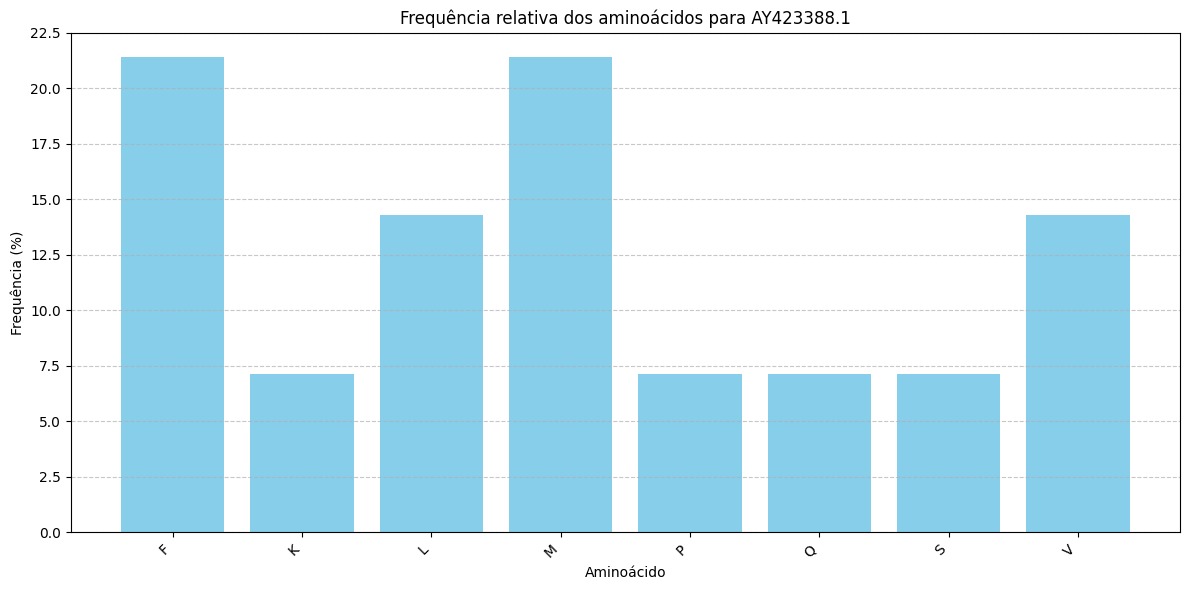

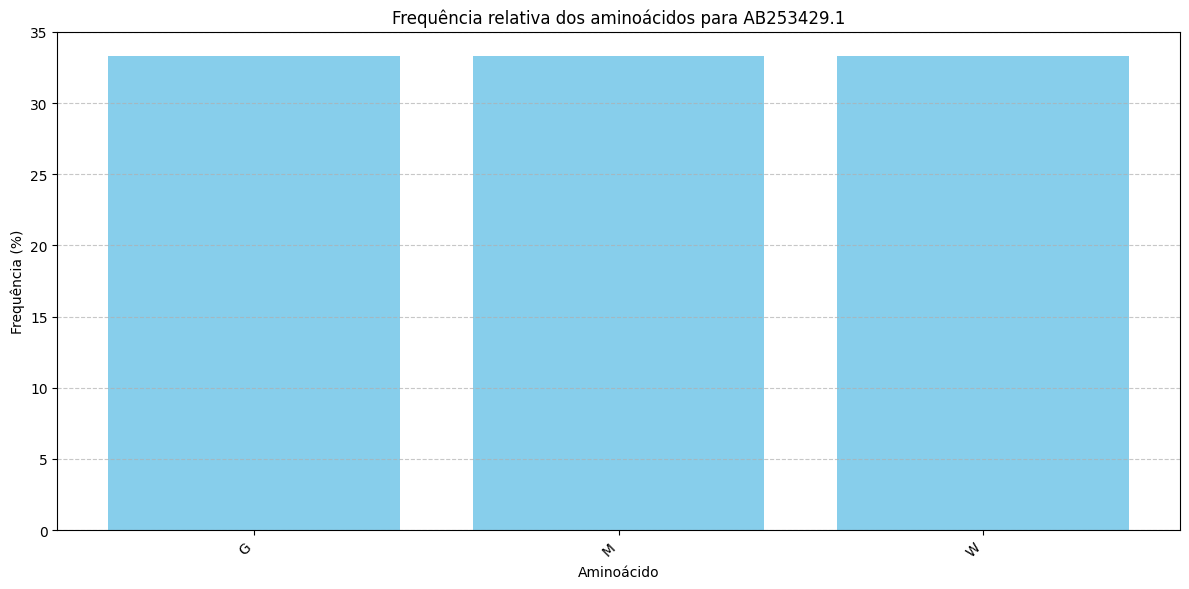

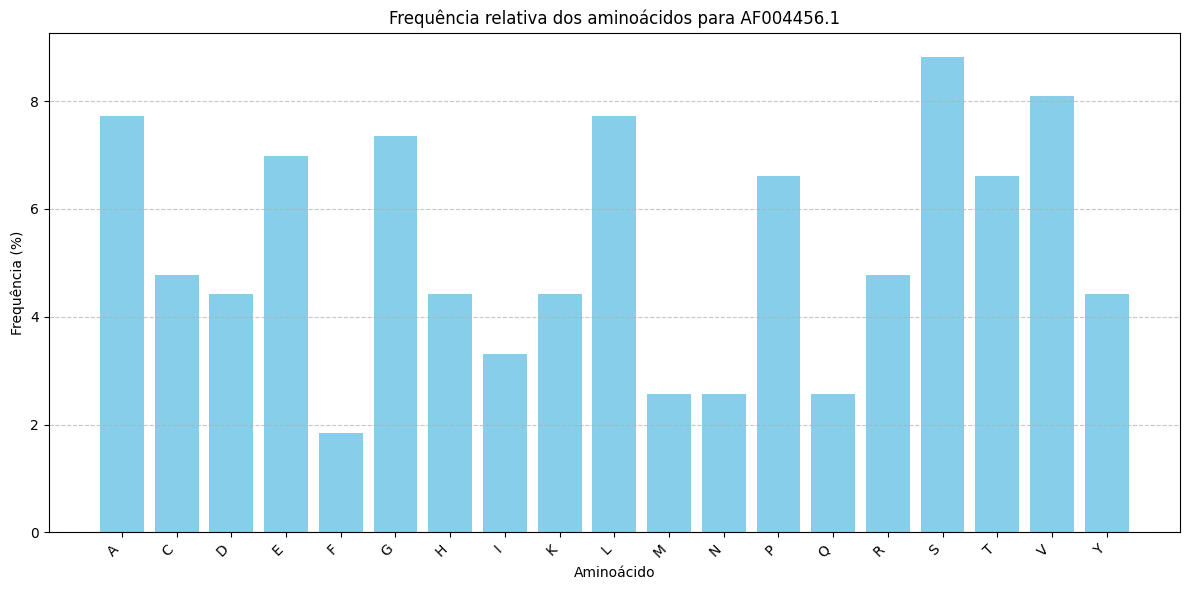

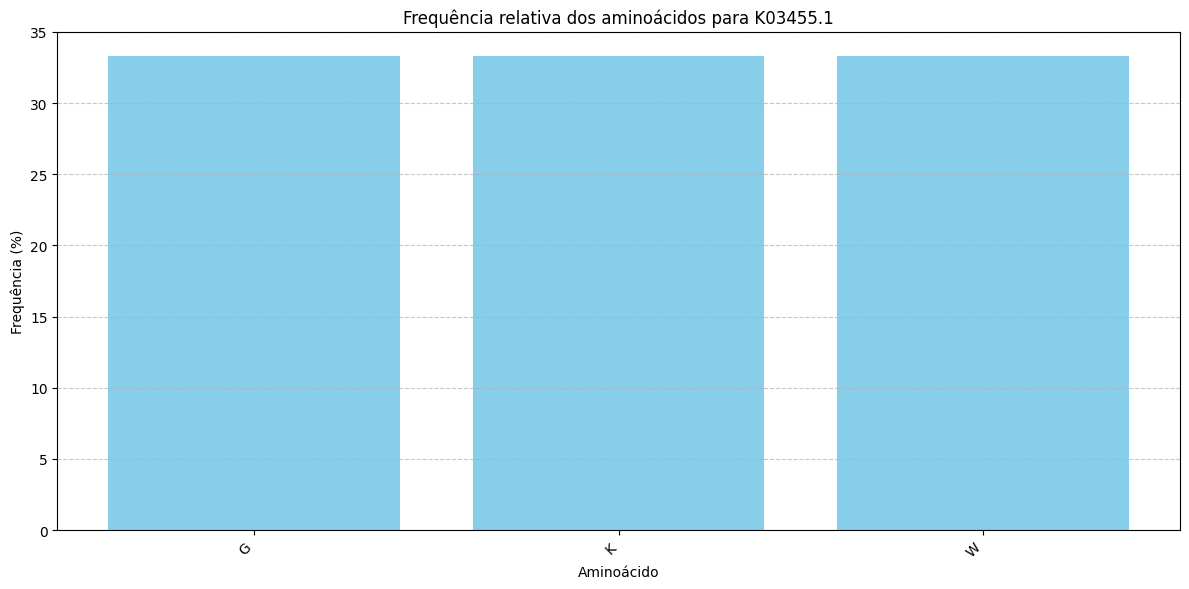

In [7]:
from alinhamento import align
from Bio import Entrez
from freq_nucleotideos import leitura
from temp_melting import calcular_tm
from tradutor import traduzir_sequencia
from typing import Tuple, List, Dict

import freq_aminoacidos as fa
import os
import time

def processArchives() -> Tuple[Dict[str, str], List[str]]:
    """
    Baixa (se não encontrados no diretório) e processa os arquivos fasta, armazenando em um dicionário com cabeçalho do arquivo como chave e sequência como item.
    Retorna um dicionário segundo essa lógia e uma lista contendo os cabeçalhos (chaves) das sequências.
    """
    Entrez.email = "beatriz.ormond@unifesp.br"
    dir = "db/fasta_archives"

    chaves = []
    sequencias = {}
    lista_ids = ['AY423387.1', 'AY423388.1', 'AB253429.1', 'AF004456', 'K03455.1']

    for id in lista_ids:
        try:
            # Caso o arquivo já exista no diretório
            cabecalho = ''
            sequencia = ''

            nome_arquivo = os.path.join(dir, id + ".fasta")
            with open(nome_arquivo, 'r') as arquivo:
                    linhas = arquivo.readlines()  # Coloca cada linha do arquivo como um elemento em uma lista
                    for linha in linhas:
                        linha = linha.strip()
                        if linha.startswith('>'):
                            cabecalho = linha[1:] # Tira o ">"
                        else:
                            sequencia += linha
    
            sequencias[cabecalho] = sequencia
            chaves.append(cabecalho)
        except FileNotFoundError:
            # Caso seja necesário baixá-lo
            print(f"Baixando o arquivo relativo ao ID: {id}")
            with Entrez.efetch (db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text') as handle:
                seq = handle.read()
            time.sleep(1) # Espera 1 seg para outro download (evitar crash)

            nome_arquivo = os.path.join(dir, id + ".fasta")
            with open(nome_arquivo, 'w') as arquivo:
                arquivo.write(seq)

            cabecalho = ''
            sequencia = ''

            with open(nome_arquivo, 'r') as arquivo:
                    linhas = arquivo.readlines()  # Coloca cada linha do arquivo como um elemento em uma lista
                    for linha in linhas:
                        linha = linha.strip()
                        if linha.startswith('>'):
                            cabecalho = linha[1:] # Tira o ">"
                        else:
                            sequencia += linha

            sequencias[cabecalho] = sequencia
            chaves.append(cabecalho)
    # Fim do processamento dos arquivos .fasta
    print("Processamento completo.\n\n")

    # Imprime o dicionário, apenas para visualização
    # for i, j in sequencias.items():
    #     print(f"Cabeçalho = {i}\n", end="")
    #     print(f"Sequência = {j}\n\n")
    
    return sequencias, chaves

def sizes(seq_dict: Dict[str, str]) -> None:
    """ Recebe o dicionário das sequências e cria um arquivo .csv contendo o tamanho de cada sequência """
    # Diretório final dos dados
    dir = "db/analysis"
    nome_arquivo = os.path.join(dir, "sequence_sizes.csv")

    # Títulos
    with open(nome_arquivo, "w") as titles:
        titles.write("ID,Size\n")

    with open(nome_arquivo, "a") as size:
        for header, seq in seq_dict.items():
            tamanho = len(seq)
            size.write(f'"{header}",{tamanho}\n')


def main():
    # Criação dos dicionários no formato Dict[cabeçalho da seq_nucleotideos, seq_nucleotideos]
    seq_dict, chaves = processArchives()
    # Informações que desejamos extrair das sequências
    sizes(seq_dict)
    leitura(seq_dict)
    calcular_tm(seq_dict)
    align(seq_dict, chaves)
    traduzir_sequencia(seq_dict)
    print("------INFORMAÇÕES EXTRAÍDAS------")

if __name__ == "__main__":
    main()

---
<a id="freq-nucleotideos"></a>
## freq_nucleotideos.py

In [8]:
from typing import Dict

import matplotlib.pyplot as plt
import os
import pandas as pd

def plotar_frequencia_nucleotideos(archive: str) -> None:
    """ Plota um gráfico contendo as frequências de cada nucleotídeo para todas as sequências simultaneamente """
    df = pd.read_csv(archive)
    df['Abbreviated_ID'] = df['ID'].apply(lambda x: x.split()[0])

    # Associação com a intenção de salvar o gráfico em formato .png
    ax = df.set_index('Abbreviated_ID')[['A','C','G','T']].plot(figsize=(10,6), kind='bar')
    fig = ax.figure

    plt.ylabel('Frequência (%)')
    plt.title('Frequência relativa dos nucleotídeos de cada sequência')
    plt.legend(title='Nucleotídeo')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.tight_layout()

    output_dir = "graficos"
    output_filename = os.path.join(output_dir, "Frequência relativa dos nucleotídeos de cada sequência.png")
    fig.savefig(output_filename)

def calculo(seq: str) -> Dict[str, float]:
    """ Calcua a frequencia de nucleotideos dos arquivos"""
    A = seq.count('A')
    C = seq.count('C')
    G = seq.count('G')
    T = seq.count('T')
    total = A + T + C + G
    return {    
        'A': A / total * 100 if total else 0,
        'C': C / total * 100 if total else 0,
        'G': G / total * 100 if total else 0,
        'T': T / total * 100 if total else 0,
    }

def salvar_frequencias_csv(header: str, seq: str, nome_saida: str) -> None:
    """ Salva as frequências de todas as sequências em um arquivo .csv """
    with open(nome_saida, 'a') as saida:
        freq = calculo(seq)
        saida.write(f'"{header}",{freq['A']:.2f},{freq['C']:.2f},{freq['G']:.2f},{freq['T']:.2f}\n')
                

def leitura(sequences_dict: Dict[str, int]) -> None:
    db_dir = "db/analysis"
    output_filename = os.path.join(db_dir, 'nuc_frequencies.csv')

    # Cria um arquivo .csv que vai conter todas as frequências
    with open(output_filename, 'w') as saida:
        saida.write('ID,A,C,G,T\n')
    # Importa as frequências para 'frequencies.csv'
    for key, sequence in sequences_dict.items(): 
        salvar_frequencias_csv(key, sequence, output_filename)

    # Plota o gráfico de frequências e salva na pasta 'graficos'
    plotar_frequencia_nucleotideos(output_filename)

---
<a id="temp-melting"></a>
## temp_melting.py

In [9]:
from typing import Dict

import os

def salvar_tm_csv(header: str, tm: float, archive: str) -> None:
    """ Armazena cada temperatura de melting em um arquivo .csv """
    with open(archive, "a") as row:
        row.write(f'"{header}",{tm}\n')

def calcular_tm(sequencias: Dict[str, str]) -> float:
    """ Calcula a temperatura de melting com base na sequência fornecida """
    # Diretório final dos dados
    dir = "db/analysis"
    output_file = os.path.join(dir, "temp_melting.csv")
    
    with open(output_file, "w") as tm_table:
        # Titulos
        tm_table.write("ID,Tm (Degree Celsius)\n")

    for key, seq in sequencias.items():
        # Essencial para calcular o conteúdo GC
        num_g = seq.count('G')
        num_c = seq.count('C')

        comprimento_sequencia = len(seq)

        # Caso de tamanho nulo
        if comprimento_sequencia == 0:
            salvar_tm_csv(key, 0.0, output_file)
            continue

        # Cálculo normal da temperatura de melting (Tm)
        Tm = 64.9 + 41 * ((num_g + num_c - 16.4) / comprimento_sequencia)
        salvar_tm_csv(key, Tm, output_file)

---
<a id="alinhamento"></a>
## alinhamento.py

In [10]:
from typing import Dict, List

import csv
import numpy as np
import os

def save_alginment_score(path_name: str, score_map: np.ndarray, headers: List[str]) -> None:
    """ Armazena o score do alinhamento no um arquivo .csv """
    # Cria os títulos para o .csv que contém os scores dos alinhamentos globais e insere os valores após
    with open(path_name, "w", newline='') as align_file:
        writer = csv.writer(align_file)

        # Escreve a linha de títulos (nomes das colunas).
        # A formatação de headers impede que as vírgulas nos cabeçalhos sejam inclusas como vírgulas do .csv
        writer.writerow(['ID'] + headers)

        # Escreve as linhas de dados
        for i in range(5):
            # Cada linha começa com o nome da sequência correspondente
            row_to_write = [headers[i]] + score_map[i, :].tolist()
            writer.writerow(row_to_write)

""" Algoritmo de Needleman-Wunsch """
def nedWun(align_mt: np.ndarray, DNAseq1: str, DNAseq2: str, rows: int, cols: int) -> np.number:
    # Penalidades
    GAP = -2
    MISMATCH = -1
    MATCH = 1

    # Insere os gaps iniciais
    align_mt[0, :] = np.arange(0, cols * GAP, GAP)
    align_mt[:, 0] = np.arange(0, rows * GAP, GAP)

    """ PRIMEIRA ETAPA: Preenchimento da matriz de alinhamento e score"""
    for i in range(rows - 1):
        for j in range(cols - 1):
            upper_value = align_mt[i, j + 1] + GAP
            side_value = align_mt[i + 1, j] + GAP
            # Verifica se há match de nucleotídeos
            if (DNAseq1[j] == DNAseq2[i]):
                diagonal_value = align_mt[i, j] + MATCH
            else:
                diagonal_value = align_mt[i, j] + MISMATCH
            
            # Encontra o maior valor e insere na posição a ser preenchida
            higher = max(upper_value, side_value, diagonal_value)
            align_mt[i + 1, j + 1] = higher

    score = align_mt[rows - 1][cols - 1]

    """ SEGUNGA ETAPA: Percorre a matriz pela extremidade oposta, retornando o alinhamento ótimo """
    DNAalign1 = ""
    DNAalign2 = ""
    i = rows - 1
    j = cols - 1
    while (i != 0 or j != 0):
        # Caso MATCH
        if (DNAseq1[j - 1] == DNAseq2[i - 1]):
            DNAalign1 = DNAseq1[j - 1] + DNAalign1
            DNAalign2 = DNAseq2[i - 1] + DNAalign2
            i -= 1
            j -= 1

        # Caso MISMATCH
        else:
            # Limite lateral
            if (j == 0):
                DNAalign1 = "-" + DNAalign1
                DNAalign2 = DNAseq2[i - 1] + DNAalign2
                i -= 1

            # Limite superior
            elif (i == 0):
                DNAalign1 = DNAseq1[j - 1] + DNAalign1
                DNAalign2 = "-" + DNAalign2
                j -= 1

            # Dentro dos limites da matriz de alinhamento
            else:
                # Desloca para a esquerda
                if (align_mt[i, j - 1] > align_mt[i - 1, j]):
                    DNAalign1 = DNAseq1[j - 1] + DNAalign1
                    DNAalign2 = "-" + DNAalign2
                    j -= 1

                # Desloca para cima
                elif (align_mt[i, j - 1] < align_mt[i - 1, j]):
                    DNAalign1 = "-" + DNAalign1
                    DNAalign2 = DNAseq2[i - 1] + DNAalign2
                    i -= 1

                # Caso de desempate, desloca na diagonal
                else:
                    DNAalign1 = DNAseq1[j - 1] + DNAalign1
                    DNAalign2 = DNAseq2[i - 1] + DNAalign2
                    i -= 1
                    j -= 1

    return score

""" Algoritmo de Smith-Waterman """
def smiWat(align_mt: np.ndarray, DNAseq1: str, DNAseq2: str, rows: int, cols: int) -> np.number:
    # Penalidades
    GAP = -2
    MISMATCH = -1
    MATCH = 1

    """ PRIMEIRA ETAPA: Preenchimento da matriz de alinhamento """
    for i in range(rows - 1):
        for j in range(cols - 1):
            upper_value = align_mt[i, j + 1] + GAP
            upper_value = max(0, upper_value)

            side_value = align_mt[i + 1, j] + GAP
            side_value = max(0, side_value)

            # Verifica se há match de nucleotídeos
            if (DNAseq1[j] == DNAseq2[i]):
                diagonal_value = align_mt[i, j] + MATCH
            else:
                diagonal_value = align_mt[i, j] + MISMATCH
            diagonal_value = max(0, diagonal_value)
            
            # Encontra o maior valor e insere na posição a ser preenchida
            higher = max(upper_value, side_value, diagonal_value)
            align_mt[i + 1, j + 1] = higher
    
    score = np.max(align_mt)
    
    """ SEGUNGA ETAPA: Percorre a matriz pela extremidade oposta, retornando o alinhamento ótimo """
    # Lista que vai conter todos os alinhamentos locais
    local_align = []

    # np.argwhere retorna uma lista de coordenadas (i, j)
    max_positions = np.argwhere(align_mt == score)

    for i, j in max_positions:
        DNAalign1 = ""
        DNAalign2 = ""
        current_i, current_j = i, j
        
        # Bactracking que para em 0
        while align_mt[current_i, current_j] != 0:
            current_score = align_mt[current_i, current_j]

            # Análise de qual direção o algoritmo vai seguir.
            # O uso de max(0, ...) é uma garantia de que temos apenas valores não negativos
            diagonal_prev = align_mt[current_i - 1, current_j - 1]
            if (DNAseq1[j - 1] == DNAseq2[i - 1]):
                diagonal_penal = MATCH
            else:
                diagonal_penal = MISMATCH
            diagonal_value = max(0, diagonal_prev + diagonal_penal)

            upper_prev = align_mt[current_i - 1, current_j]
            upper_value = max(0, upper_prev + GAP)

            side_prev = align_mt[current_i, current_j - 1]
            side_value = max(0, side_prev + GAP)

            # Decisão de caminho
            # MATCH ou MISMATCH
            if current_score == diagonal_value and current_score != 0 and align_mt[current_i - 1, current_j - 1] >= 0: # Para garantir que não veio de um 0 resetado
                DNAalign1 = DNAseq1[j - 1] + DNAalign1
                DNAalign2 = DNAseq2[i - 1] + DNAalign2
                current_i -= 1
                current_j -= 1
            # GAP
            elif current_score == upper_value and current_score != 0 and align_mt[current_i - 1, current_j] >= 0:
                DNAalign1 = "-" + DNAalign1
                DNAalign2 = DNAseq2[i - 1] + DNAalign2
                current_i -= 1
            elif current_score == side_value and current_score != 0 and align_mt[current_i, current_j - 1] >= 0:
                DNAalign1 = DNAseq1[j - 1] + DNAalign1
                DNAalign2 = "-" + DNAalign2
                current_j -= 1
            else:
                break

        local_align.insert(0, (DNAalign1, DNAalign2, score))

    return score

                
def align(seq_dict: Dict[str, str], headers: List[str]) -> None:
    # Caminho para o diretório final
    dir_name = "db/analysis"
    output_global_file = os.path.join(dir_name, "global_alignment.csv")
    output_local_file = os.path.join(dir_name, "local_alignment.csv")

    # Matrizes de score
    global_scores = np.zeros((5,5))
    local_scores = np.zeros((5,5))

    for i in range(5):
        for j in range(5):
            if (i == j):
                global_scores[i, j] = 0
                local_scores[i, j] = 0
            else:
                # Seleciona apenas os 300 primeiros nucleotídeos
                DNAseq1 = seq_dict[headers[i]][:300]
                DNAseq2 = seq_dict[headers[j]][:300]
                cols = len(DNAseq1) + 1
                rows = len(DNAseq2) + 1
                # Matrizes de alinhamento
                global_align_mt = np.zeros((rows, cols))
                local_align_mt = np.zeros((rows, cols))
                # Calcula os alinhamentos e scores
                global_scores[i, j] = nedWun(global_align_mt, DNAseq1, DNAseq2, rows, cols)
                local_scores[i, j] = smiWat(local_align_mt, DNAseq1, DNAseq2, rows, cols)

    # Insere os valores nos respectivos .csv
    save_alginment_score(output_global_file, global_scores, headers)
    save_alginment_score(output_local_file, local_scores, headers)

---
<a id="tradutor"></a>
## tradutor.py

In [11]:
from typing import Dict

import freq_aminoacidos as fa
import os

# --- Tabela de Códons Padrão ---
# Esta é uma tabela de códons padrão para a tradução de RNA para aminoácidos.
# 'U' é usado para Uracil, como em RNA.
CODONS_TABLE: Dict[str, str] = {
    'UUU': 'F', 'UUC': 'F', 'UUA': 'L'   , 'UUG': 'L'   ,
    'UCU': 'S', 'UCC': 'S', 'UCA': 'S'   , 'UCG': 'S'   ,
    'UAU': 'Y', 'UAC': 'Y', 'UAA': 'STOP', 'UAG': 'STOP',
    'UGU': 'C', 'UGC': 'C', 'UGA': 'STOP', 'UGG': 'W'   ,
    'CUU': 'L', 'CUC': 'L', 'CUA': 'L'   , 'CUG': 'L'   ,
    'CCU': 'P', 'CCC': 'P', 'CCA': 'P'   , 'CCG': 'P'   ,
    'CAU': 'H', 'CAC': 'H', 'CAA': 'Q'   , 'CAG': 'Q'   ,
    'CGU': 'R', 'CGC': 'R', 'CGA': 'R'   , 'CGG': 'R'   ,
    'AUU': 'I', 'AUC': 'I', 'AUA': 'I'   , 'AUG': 'M'   , # AUG é Metionina e códon de início
    'ACU': 'T', 'ACC': 'T', 'ACA': 'T'   , 'ACG': 'T'   ,
    'AAU': 'N', 'AAC': 'N', 'AAA': 'K'   , 'AAG': 'K'   ,
    'AGU': 'S', 'AGC': 'S', 'AGA': 'R'   , 'AGG': 'R'   ,
    'GUU': 'V', 'GUC': 'V', 'GUA': 'V'   , 'GUG': 'V'   ,
    'GCU': 'A', 'GCC': 'A', 'GCA': 'A'   , 'GCG': 'A'   ,
    'GAU': 'D', 'GAC': 'D', 'GAA': 'E'   , 'GAG': 'E'   ,
    'GGU': 'G', 'GGC': 'G', 'GGA': 'G'   , 'GGG': 'G'
}


## G) Síntese Proteica (Tradução) e Frequência de Aminoácidos

### a. Implementar função de tradução

def traduzir_sequencia(sequencias: Dict[str, str]) -> None:
    """
    Realiza a tradução de uma sequência de nucleotídeos (DNA ou RNA)
    para uma sequência de aminoácidos.
    Para simplificar, a tradução ocorre a partir da primeira fase de leitura,
    parando no primeiro códon de parada ou no final da sequência.
    Códons não encontrados são identificados com 'X'.

    Args:
        sequencia (Dict[str, str]): Dicionário com todas as sequências de 
                                    nucleotídeos (DNA ou RNA) a ser traduzidos.
    """

    # Diretório de armazenamento do .csv
    output_dir = "db/analysis"
    output_file = os.path.join(output_dir, "aa_translation.csv")

    # Escrita dos títulos do .csv
    with open(output_file, "w") as titles:
        titles.write("ID,Amino acid\n")

    # Algoritmo principal de tradução
    for key, sequencia_nucleotideos in sequencias.items():  
        proteina = ""
        # Converte T (Timina, DNA) para U (Uracila, RNA) para a tradução
        # já que a tabela de códons é baseada em RNA.
        sequencia_rna = sequencia_nucleotideos.upper().replace('T', 'U')

        i = 0
        while i + 2 < len(sequencia_rna):
            codon = sequencia_rna[i:i+3]
            aminoacido = CODONS_TABLE.get(codon, 'X') # Retorna 'X' se o códon não for encontrado
            if aminoacido == 'STOP':
                break # Para a tradução se um códon de parada for encontrado
            proteina += aminoacido
            i += 3
        
        # Calcula as frequências, insere no dicionário de frequências e plota as frequências relativas
        frequencias = fa.calcular_frequencia_aminoacidos(proteina)
        fa.plotar_frequencia_aminoacidos(frequencias, key)

        # Insere o aminoácido traduzido no .csv
        with open(output_file, "a") as aa:
            aa.write(f'"{key}",{proteina}\n')

---
<a id="freq-aminoacidos"></a>
## freq_aminoacidos.py

In [12]:
from typing import Dict, List

import collections
import matplotlib.pyplot as plt
import os

def calcular_frequencia_aminoacidos(sequencia_proteica: str) -> Dict[str, float]:
    """
    Calcula a frequência (em porcentagem) de cada aminoácido em uma
    sequência proteica.

    Args:
        sequencia_proteica (str): A sequência de aminoácidos.

    Returns:
        dict: Um dicionário onde as chaves são os aminoácidos e os valores
              são suas frequências em porcentagem.
    """
    if not sequencia_proteica:
        return {}

    contagem_aminoacidos: Dict[str, int]  = collections.Counter(sequencia_proteica)
    total_aminoacidos: int = len(sequencia_proteica)
    frequencias:Dict[str, float] = {aa: (count / total_aminoacidos) * 100 for aa, count in contagem_aminoacidos.items()}
    return frequencias

def plotar_frequencia_aminoacidos(frequencias: Dict[str, float], cabecalho) -> None:
    """
    Plota um gráfico de barras mostrando a frequência de aminoácidos.

    Args:
        frequencias (dict): Dicionário com aminoácidos e suas frequências.
        titulo (str): Título do gráfico.
    """
    # Extrai o ID do cabeçalho
    cabecalho_separado = cabecalho.split()
    ID = cabecalho_separado[0]
    titulo = f"Frequência relativa dos aminoácidos para {ID}"

    if not frequencias:
        print(f"Não há dados para plotar para: {titulo}")
        return

    # Ordena os aminoácidos alfabeticamente para consistência no gráfico
    aminoacidos_ordenados: List[str] = sorted(frequencias.keys())
    valores_frequencia: List[float] = [frequencias[aa] for aa in aminoacidos_ordenados]

    fig = plt.figure(figsize=(12, 6))
    plt.bar(aminoacidos_ordenados, valores_frequencia, color='skyblue')
    plt.xlabel("Aminoácido")
    plt.ylabel("Frequência (%)")
    plt.title(titulo)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    output_dir: str = "graficos"
    output_filename: str = os.path.join(output_dir, f"{titulo}.png")
    fig.savefig(output_filename)